In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from skimage.measure import compare_ssim as ssim
import matplotlib.pyplot as plt
import time
import os
import random
import copy
import math
import h5py
import sys
import torch
import scipy.stats
from PIL import Image
import gc

sys.path.append('../../../code')

from python.finetune_commons import show_images, ft_train_model, visualize_model
from python.commons import load_dict_from_hdf5, save_dict_to_hdf5, inc_inference_e2e, full_inference_e2e, adaptive_drilldown, generate_heatmap
from python.vgg16 import VGG16
from python.resnet18 import ResNet18
from python.inception3 import Inception3

random.seed(45)
np.random.seed(45)

torch.set_num_threads(8)

%matplotlib inline

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    if math.isnan(h):
        h = 0
    return m, h

In [3]:
n_labels = 1000
gpu = True
c = 0.5

image_files = []
temp = os.listdir('../../../data/oct/test/DRUSEN')
for name in temp:
    if name.endswith('jpeg'):
        image_files.append('../../../data/oct/test/DRUSEN/'+name)

temp = os.listdir('../../../data/oct/test/DME')
for name in temp:
    if name.endswith('jpeg'):
        image_files.append('../../../data/oct/test/DME/'+name)
        
temp = os.listdir('../../../data/oct/test/CNV')
for name in temp:
    if name.endswith('jpeg'):
        image_files.append('../../../data/oct/test/CNV/'+name)
        
        
temp = os.listdir('../../../data/oct/test/NORMAL')        
for name in temp:
    if name.endswith('jpeg'):
        image_files.append('../../../data/oct/test/NORMAL/'+name)

file_amount = 30
image_files = random.sample(image_files, file_amount)

In [4]:
def get_image(file_path, image_size):
    
    loader = transforms.Compose([transforms.Resize([image_size, image_size]), transforms.ToTensor()])
    
    orig_image = torch.FloatTensor(1, 3, image_size, image_size)

    temp_image = Image.open(file_path).convert('RGB')
    temp_image = loader(temp_image)
    orig_image[0] = temp_image

    if gpu:
        orig_image = orig_image.cuda()
        
    return orig_image

/usr/local/lib/python2.7/dist-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


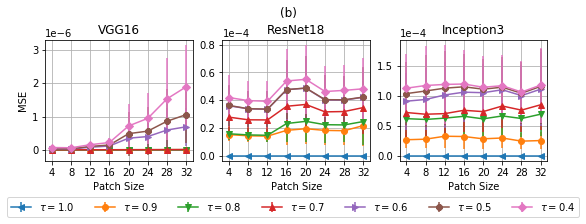

In [5]:
patch_sizes = [4, 8, 12, 16, 20, 24, 28, 32]
markers = ['<', 'o', 'v', '^', '>', '8', 'D']

plt.figure(figsize=(9,2.5))

i = 1

for model,model_name,weight_file, image_size in zip([VGG16, ResNet18, Inception3], ['VGG16', 'ResNet18', 'Inception3'],
                                       ['../../../code/python/vgg16_weights_ptch.h5',
                                       '../../../code/python/resnet18_weights_ptch.h5',
                                        '../../../code/python/inception3_weights_ptch.h5',
                                       ], [224, 224, 299]):
    
    
    for beta,m in zip([1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4], markers):        
        r = []
        ci = []
        ax = plt.subplot(1, 3, i)
        for patch_size in patch_sizes:
                            
            temp = []
            
            for file_path in image_files:
                orig_image = get_image(file_path, image_size)
                weights_data = load_dict_from_hdf5(weight_file, gpu=True)
                inc_model = model(beta=1.0, gpu=gpu, n_labels=n_labels, weights_data=weights_data).cuda()
                inc_model.forward_materialized(orig_image)
            
                image_patches = torch.FloatTensor(1, 3, patch_size, patch_size).fill_(c)

                ####### tau=1.0 #######                
                locations = torch.zeros([1, 2], dtype=torch.int32)
                locations[0][0] = (image_size-patch_size)//2
                locations[0][1] = (image_size-patch_size)//2

                logits_10 = inc_model.forward_gpu(image_patches, locations, p_height=patch_size, p_width=patch_size)

                ###### tau <= 1.0 ######
                locations[0][0] = (image_size-patch_size)//2
                locations[0][1] = (image_size-patch_size)//2

                #inc_model.forward_materialized(orig_image)
                weights_data = load_dict_from_hdf5(weight_file, gpu=True)
                inc_model = model(beta=beta, gpu=gpu, n_labels=n_labels, weights_data=weights_data).cuda()
                inc_model.forward_materialized(orig_image)
                logits = inc_model.forward_gpu(image_patches, locations, p_height=patch_size, p_width=patch_size)
                
                temp2 = logits_10 - logits
                temp2 = temp2.cpu().data.numpy()
                temp2 = np.square(temp2)
                temp2 = np.mean(temp2)
                
                temp.append(temp2)
            
            mean,h = mean_confidence_interval(temp)
            r.append(mean)
            ci.append(h)

        ax.errorbar(patch_sizes, r, yerr=ci, marker=m, label=r'$\tau = $' + str(beta))
        ax.set_title(model_name)
        plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

    plt.grid()
    plt.xlabel('Patch Size')
    plt.xticks(patch_sizes, patch_sizes)

    if i == 1:
        plt.ylabel('MSE')

    i = i + 1
    
lgd = plt.legend(loc='lower center', ncol=7, bbox_to_anchor=[-0.72, -.5])
stit = plt.suptitle('(b)')
plt.subplots_adjust(top=0.8)
plt.savefig('../images/mse_thresholding_oct.pdf', bbox_extra_artists=(lgd,stit,), bbox_inches='tight')
plt.show()